In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import rl

%matplotlib inline


matplotlib = rl.plot_utils.set_mpl_defaults(matplotlib)

# Task Setup

## Multiple State Task
First, we set up a reversal learning task, modeled after the task used in Lefebvre et al. (2017).


In [5]:
# %% 1.1 Set up Reversal-Learning-Task (rv) from Kahnt, Park et al. (2008)
# ------------------------------------------------------------------------
print("1.1 Set up Reversal-Learning-Task (rv) from Kahnt, Park et al. (2008)")
print("---------------------------------------------------------------------")

# Set up the different states
ms_states = {
    0: {"p_r": [0.25, 0.25], "a_correct": [0, 1], "rewards": [0.5, -0.5]},
    1: {"p_r": [0.75, 0.25], "a_correct": [0], "rewards": [0.5, -0.5]},
    2: {"p_r": [0.25, 0.75], "a_correct": [1], "rewards": [0.5, -0.5]},
    3: {"p_r": [0.75, 0.75], "a_correct": [0, 1], "rewards": [0.5, -0.5]},
}

# Build sequence of trials / states (n_blocks x n_trials)
n_blocks = 2
n_trials = 100
n_states = len(ms_states)
state_sequence = np.repeat(
    np.repeat(np.arange(n_states), n_trials // n_states)[:, None], n_blocks, axis=1,
)

## Shuffle within each block
[
    np.random.shuffle(state_sequence[:, block])
    for block in range(state_sequence.shape[1])
]

# Set up task
ms_task_vars = rl.task.TaskVars(
    n_options=2, states=ms_states, state_sequence=state_sequence.T
)
ms_task = rl.task.MultipleStateTask(task_vars=ms_task_vars)
print(ms_task)

1.1 Set up Reversal-Learning-Task (rv) from Kahnt, Park et al. (2008)
---------------------------------------------------------------------
Multiple-state learning task with the states:
  {0: {'p_r': [0.25, 0.25], 'a_correct': [0, 1], 'rewards': [0.5, -0.5]}, 1: {'p_r': [0.75, 0.25], 'a_correct': [0], 'rewards': [0.5, -0.5]}, 2: {'p_r': [0.25, 0.75], 'a_correct': [1], 'rewards': [0.5, -0.5]}, 3: {'p_r': [0.75, 0.75], 'a_correct': [0, 1], 'rewards': [0.5, -0.5]}}


# Agent

Next, we set up an dual learning rate agent to perform the task with known parameters $\alpha^{+}$, $\alpha^{-}$ and $\beta$:

In [16]:
# %% 2. Set up Dual-Learning-Rate Agent
# -------------------------------------
print("2. Set up Dual-Learning-Rate Agent")
print("----------------------------------")


# Use mean parameters from Lefebvre et al. (2017)
agent_vars = rl.agent.AgentVars(
    alpha_pos=0.36, alpha_neg=0.22, beta=(1 / 0.13), variant="delta"
)
agent = rl.agent.DualLearningRateAgent(
    agent_vars=agent_vars,
    n_options=ms_task.task_vars.n_options,
    n_states=len(ms_states),
)
print(agent)

2. Set up Dual-Learning-Rate Agent
----------------------------------
Dual learning rate agent (delta variant) with
  alpha_pos = 0.36
  alpha_neg = 0.22
  beta = 7.69


# Interaction

Now, we can let the agent perform the task:

In [17]:
np.random.seed(1)
df = rl.interaction.agent_task_interaction(ms_task, agent)
df.head(10)

,trial,block,state,p_r_0,ev_0,p_r_1,ev_1,r,a,s,corr,p_a_0,Q_0,p_a_1,Q_1,ll
0,0.0,0.0,1.0,0.75,0.25,0.25,-0.25,0.5,0.0,1.0,1.0,0.500000,0.000000,0.500000,0.0,-0.693147
1,1.0,0.0,0.0,0.25,-0.25,0.25,-0.25,-0.5,0.0,0.0,1.0,0.500000,0.000000,0.500000,0.0,-0.693147
2,2.0,0.0,3.0,0.75,0.25,0.75,0.25,0.5,0.0,3.0,1.0,0.500000,0.000000,0.500000,0.0,-0.693147
3,3.0,0.0,0.0,0.25,-0.25,0.25,-0.25,-0.5,0.0,0.0,1.0,0.300240,-0.110000,0.699760,0.0,-1.203172
4,4.0,0.0,2.0,0.25,-0.25,0.75,0.25,-0.5,0.0,2.0,0.0,0.500000,0.000000,0.500000,0.0,-0.693147
5,5.0,0.0,3.0,0.75,0.25,0.75,0.25,0.5,0.0,3.0,1.0,0.799731,0.180000,0.200269,0.0,-0.223480
6,6.0,0.0,0.0,0.25,-0.25,0.25,-0.25,-0.5,1.0,0.0,1.0,0.181509,-0.195800,0.818491,0.0,-0.200293
7,7.0,0.0,3.0,0.75,0.25,0.75,0.25,0.5,0.0,3.0,1.0,0.906427,0.295200,0.093573,0.0,-0.098245
8,8.0,0.0,2.0,0.25,-0.25,0.75,0.25,0.5,1.0,2.0,1.0,0.300240,-0.110000,0.699760,0.0,-0.357018
9,9.0,0.0,3.0,0.75,0.25,0.75,0.25,0.5,0.0,3.0,1.0,0.944690,0.368928,0.055310,0.0,-0.056898


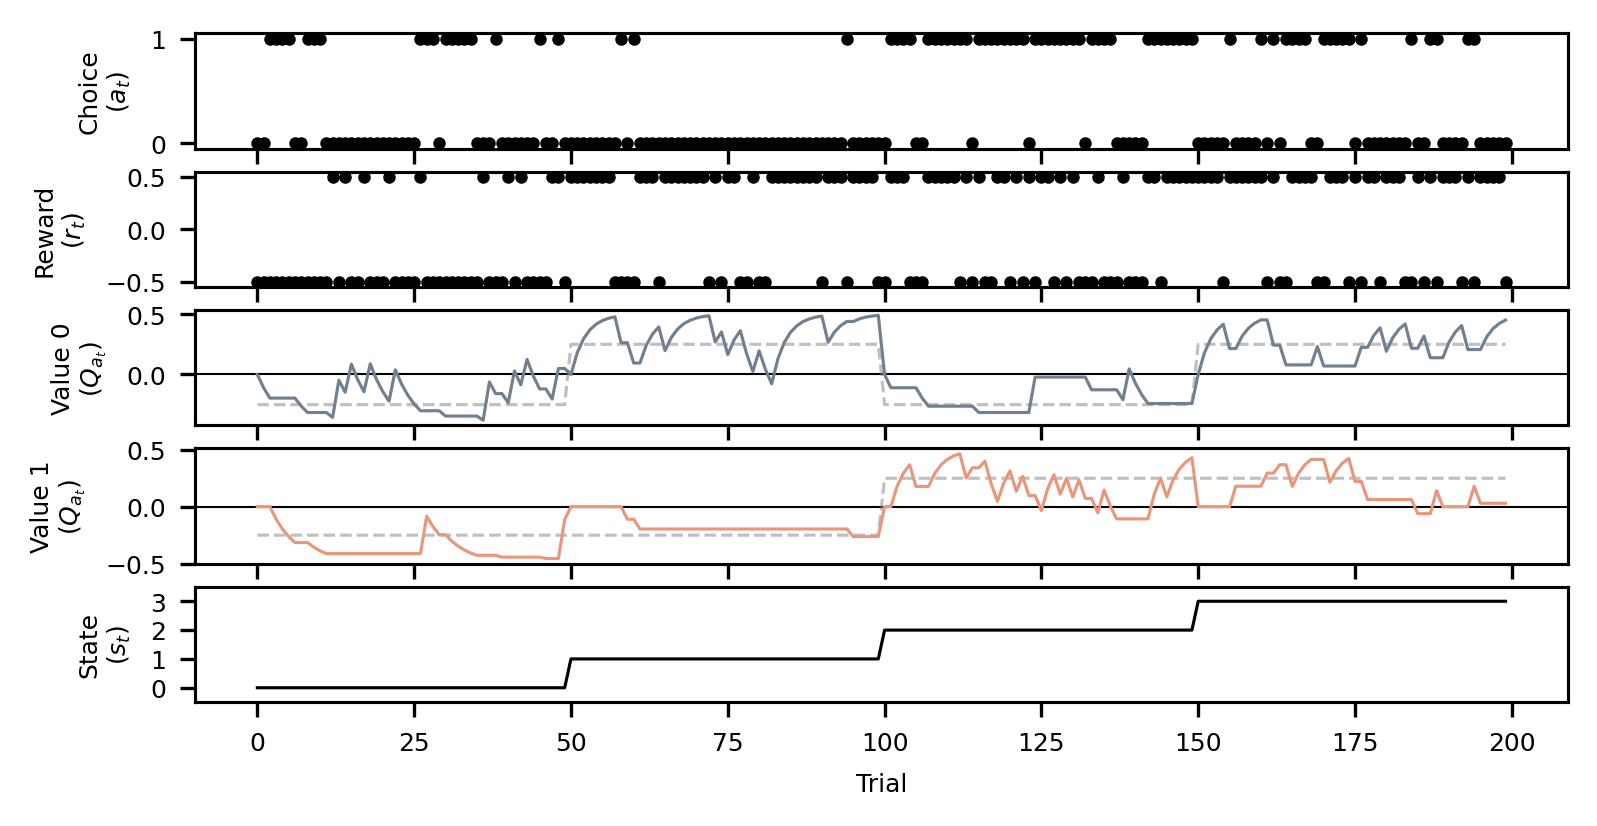

In [18]:
rl.plots.plot_data(data=df.sort_values(["state", "trial"]).reset_index(drop=True));

# Estimation

Given the behavioural data, we can try to estimate the agent's parameters:

In [19]:
# Define parameters to estimate
parameters = ["alpha_pos", "alpha_neg", "beta"]

# Set boundaries (used to initialize and constrain estimation)
bounds = {"alpha_pos": (0, 1), "alpha_neg": (0, 1), "beta": (0, 20)}

# Initialize estimation variables and estimation instance
# Note, that we also need to specify the agent_class (i.e., the agent "model")
est_vars = rl.estimation.EstimationVars(
    ms_task_vars,
    agent_class=rl.agent.DualLearningRateAgent,
    parameters=parameters,
    bounds=bounds,
    n_sp=10,
)
est = rl.estimation.Estimation(est_vars)

In [20]:
# We can compute the neggative log-likelihood (nll) of the data, given the true parameters, as a reference:
est.nll(
    x=[agent.agent_vars.alpha_pos, agent.agent_vars.alpha_neg, agent.agent_vars.beta],
    data=df,
    agent_vars=agent_vars,
)

99.86594279040364

In [22]:
# Now we can estimate the maximum likelihood parameters
result = est.estimate(data=df, agent_vars=agent_vars, seed=1)
result

(82.2498456105204,
 180.3946433206849,
 [0.6552559209730585, 0.396234859500562, 3.8443721935361044])

The estimated parameters are close to, but not identical to the true parameters. We can simulate data from an agent using the estimated parameters and compare the prediction to the original data on different measures:

In [26]:
est_agent_vars = rl.agent.AgentVars(
    alpha_pos=result[2][0], alpha_neg=result[2][1], beta=result[2][2], variant="delta"
)
est_agent = rl.agent.DualLearningRateAgent(
    agent_vars=est_agent_vars,
    n_options=ms_task.task_vars.n_options,
    n_states=len(ms_states),
)
est_agent

Dual learning rate agent (delta variant) with
  alpha_pos = 0.66
  alpha_neg = 0.40
  beta = 3.84

In [27]:
np.random.seed(1)
pred = rl.interaction.agent_task_interaction(task=ms_task, agent=est_agent)
pred.head()

,trial,block,state,p_r_0,ev_0,p_r_1,ev_1,r,a,s,corr,p_a_0,Q_0,p_a_1,Q_1,ll
0,0.0,0.0,1.0,0.75,0.25,0.25,-0.25,0.5,0.0,1.0,1.0,0.500000,0.000000,0.500000,0.0,-0.693147
1,1.0,0.0,0.0,0.25,-0.25,0.25,-0.25,-0.5,0.0,0.0,1.0,0.500000,0.000000,0.500000,0.0,-0.693147
2,2.0,0.0,3.0,0.75,0.25,0.75,0.25,0.5,0.0,3.0,1.0,0.500000,0.000000,0.500000,0.0,-0.693147
3,3.0,0.0,0.0,0.25,-0.25,0.25,-0.25,-0.5,0.0,0.0,1.0,0.318291,-0.198117,0.681709,0.0,-1.144789
4,4.0,0.0,2.0,0.25,-0.25,0.75,0.25,-0.5,0.0,2.0,0.0,0.500000,0.000000,0.500000,0.0,-0.693147


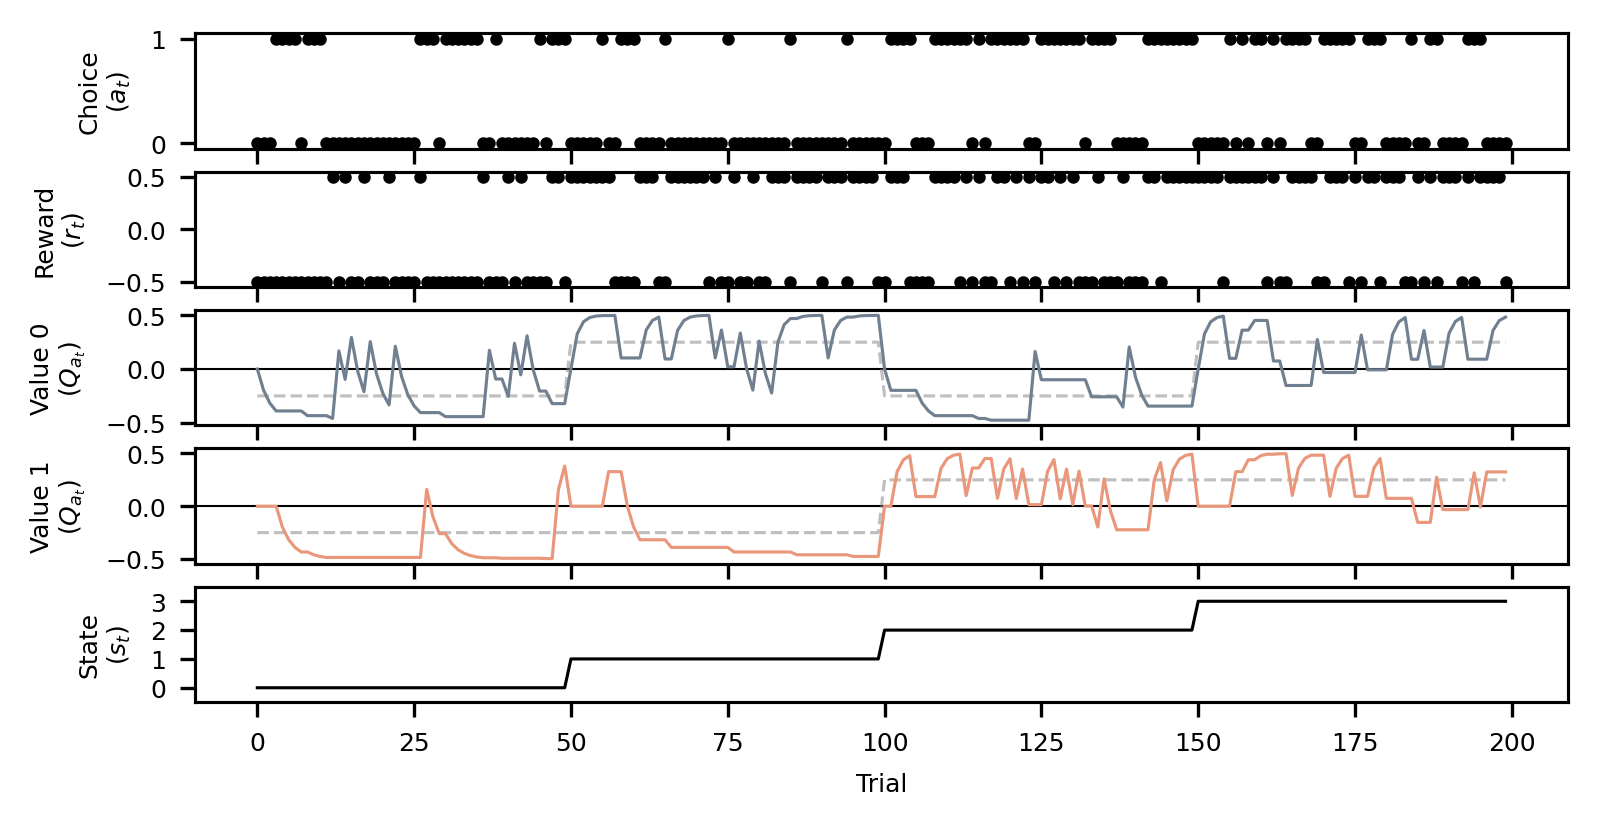

In [29]:
rl.plots.plot_data(pred.sort_values(["state", "trial"]).reset_index(drop=True));

TODO: What measures to look at here?

# Recovery

## Multiple-state task

In [30]:
ms_task

Multiple-state learning task with the states:
  {0: {'p_r': [0.25, 0.25], 'a_correct': [0, 1], 'rewards': [0.5, -0.5]}, 1: {'p_r': [0.75, 0.25], 'a_correct': [0], 'rewards': [0.5, -0.5]}, 2: {'p_r': [0.25, 0.75], 'a_correct': [1], 'rewards': [0.5, -0.5]}, 3: {'p_r': [0.75, 0.75], 'a_correct': [0, 1], 'rewards': [0.5, -0.5]}}

In [45]:
# Set up agent
agent_vars = rl.agent.AgentVars(
    alpha_pos=np.nan, alpha_neg=np.nan, beta=np.nan, variant="delta"
)
agent = rl.agent.DualLearningRateAgent(
    agent_vars=agent_vars,
    n_options=ms_task.task_vars.n_options,
    n_states=len(ms_states),
)
agent

Dual learning rate agent (r variant) with
  alpha_pos = nan
  alpha_neg = nan
  beta = nan

In [46]:
# Set up parameter ranges
alpha_pos_values = {
    "variable": np.linspace(0, 1.0, 10),
    "low": 0.1,
    "medium": 0.3,
    "high": 0.6,
}
alpha_neg_values = {
    "variable": np.linspace(0, 1.0, 10),
    "low": 0.1,
    "medium": 0.3,
    "high": 0.6,
}
beta_values = {"variable": np.linspace(1, 10, 10), "low": 3, "medium": 5, "high": 10}
parameter_values = {
    "alpha_pos": alpha_pos_values,
    "alpha_neg": alpha_neg_values,
    "beta": beta_values,
}

In [47]:
# Set up estimation
est_vars = rl.estimation.EstimationVars(
    task_vars=ms_task_vars,
    agent_class=rl.agent.DualLearningRateAgent,
    parameters=["alpha_pos", "alpha_neg", "beta"],
    bounds={"alpha_pos": (0, 1), "alpha_neg": (0, 1), "beta": (0, 20)},
    n_sp=1,
)
est = rl.estimation.Estimation(est_vars=est_vars)

In [48]:
recovery_results = rl.recovery.run_systematic_recovery(ms_task, agent, est, parameter_values)

In [53]:
recovery_results.head()

,variable,alpha_pos,alpha_neg,beta,alpha_pos_hat,alpha_neg_hat,beta_hat,n_trials,n_blocks,n_sp,alpha_pos_level,alpha_neg_level,beta_level
0,alpha_pos,0.000000,0.1,3.0,0.176999,0.454058,1.642859,100,2,1,variable,low,low
1,alpha_pos,0.111111,0.1,3.0,0.147899,0.344186,3.595195,100,2,1,variable,low,low
2,alpha_pos,0.222222,0.1,3.0,0.227567,0.578581,4.051985,100,2,1,variable,low,low
3,alpha_pos,0.333333,0.1,3.0,0.176376,0.008232,3.141249,100,2,1,variable,low,low
4,alpha_pos,0.444444,0.1,3.0,0.690241,0.029981,2.570143,100,2,1,variable,low,low


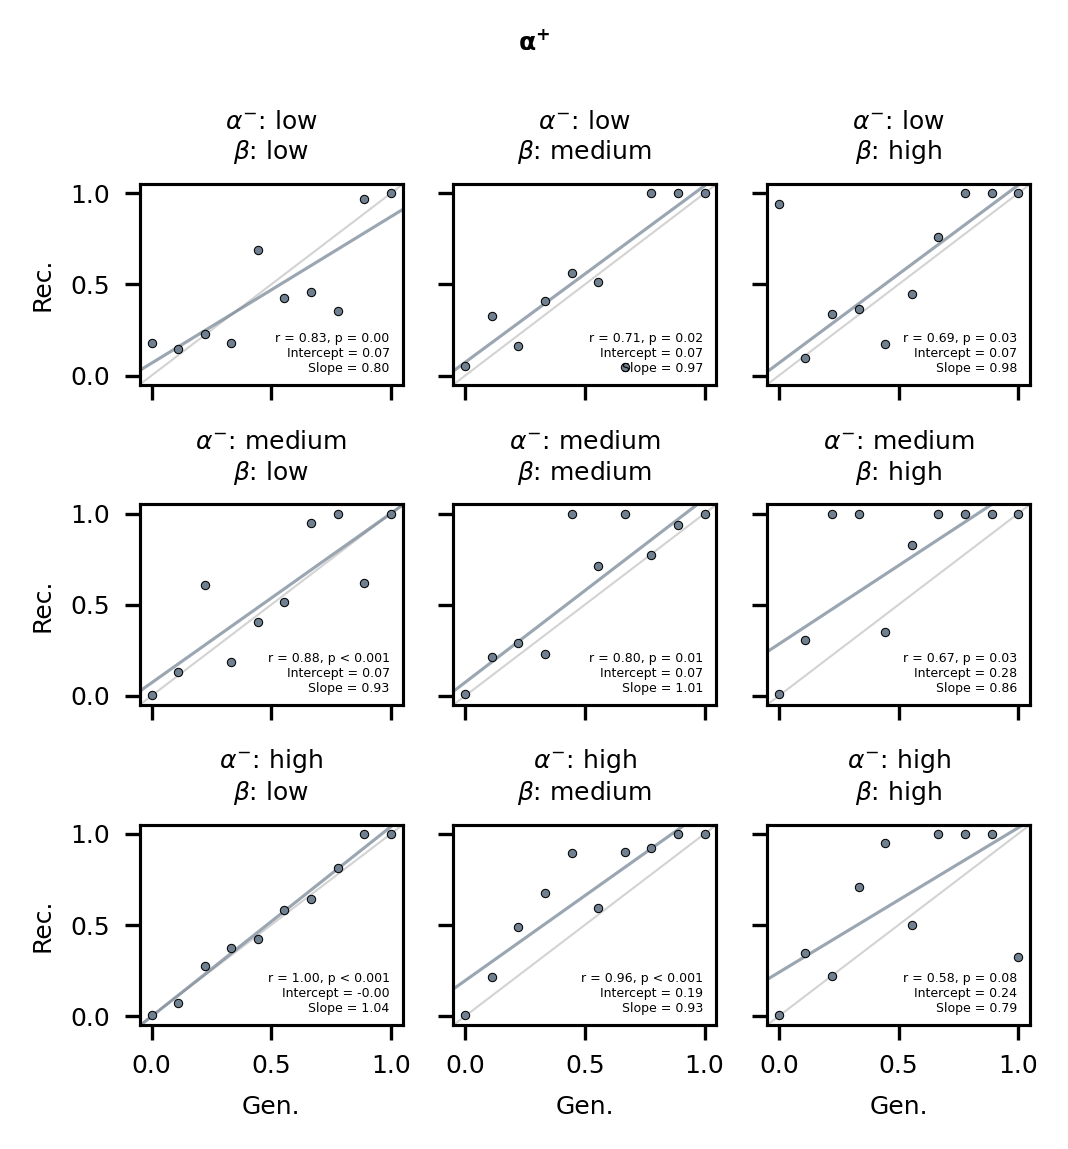

In [54]:
rl.plots.plot_recovery_results(
    recovery_results, "alpha_pos", ticks=np.linspace(0, 1, 3), limits=[-0.05, 1.05]
);

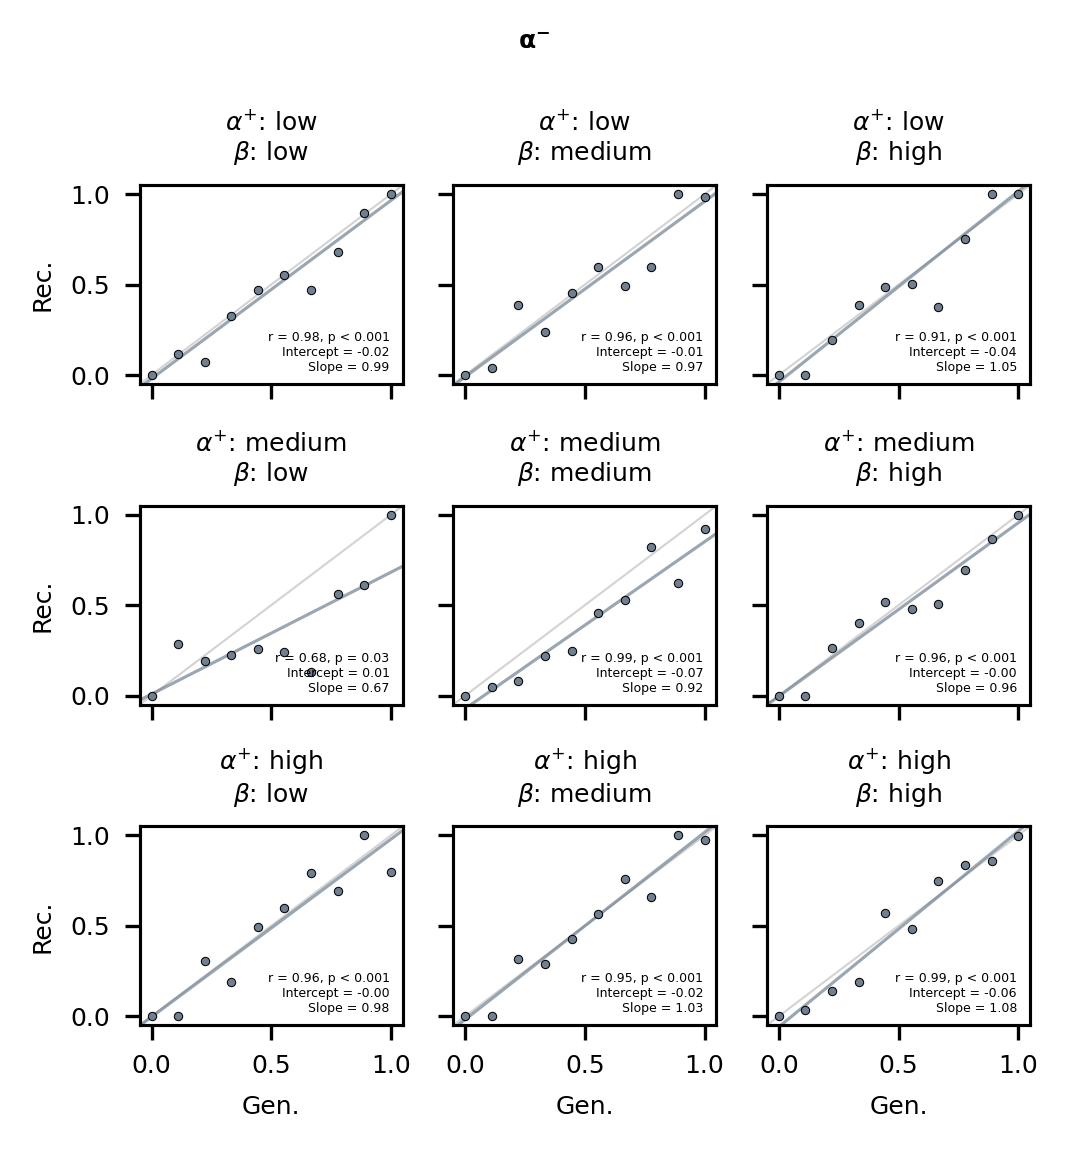

In [55]:
rl.plots.plot_recovery_results(
    recovery_results, "alpha_neg", ticks=np.linspace(0, 1, 3), limits=[-0.05, 1.05]
);

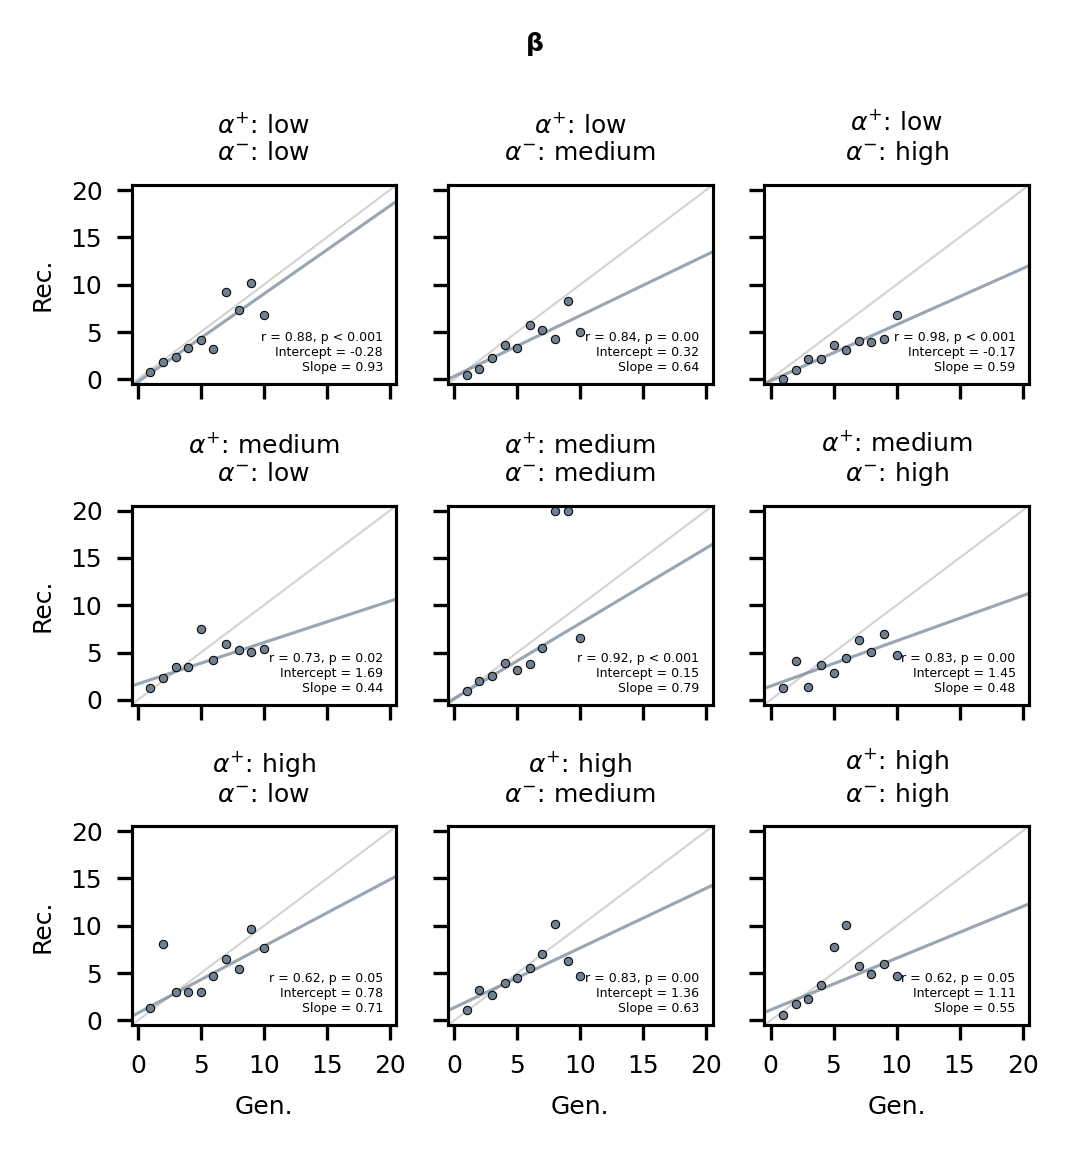

In [56]:
rl.plots.plot_recovery_results(
    recovery_results, "beta", ticks=np.linspace(0, 20, 5), limits=[-0.5, 20.5]
);